In [1]:
import tensorflow.keras as keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import callbacks
from tensorflow.keras.initializers import VarianceScaling, lecun_normal, glorot_uniform
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import seaborn as sns
from nltk.corpus import stopwords

In [2]:
from clustering_class import *
from combine_models import *

from DEC import *
from generate_word_vector import *

%load_ext autoreload
%autoreload 2

English

In [4]:
ret = pd.read_csv("data/full stock price 20150101-20191231.csv", index_col=0)
des = pd.read_csv("bert_output_bbg_eng.csv", index_col=0)
seg = pd.read_csv("data/bbg_gics_ch.csv",names=["company","industry"],dtype=str)
seg = seg.dropna()
seg['company']=seg['company'].map(lambda x: x+'.SH' if (x[0]=='6' or x[0]=='9') else x+'.SZ')
des = des.merge(seg,how='inner',on='company')
des['industry'] = des['industry'].map(lambda x: x[:6])

F:\programs\Miniconda3\envs\hejj3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
des.head()

,company,intro,introLen,lemma,intro_lemmatized,bert_vec,industry
0,600000.SH,"Shanghai Pudong Development Bank Co., Ltd. pro...",266,"['shanghai', 'pudong', 'development', 'bank', ...",shanghai pudong development bank co ltd provid...,"[-1.3002316, -1.1620108, -0.526951, -0.6841726...",401010
1,600004.SH,"Guangzhou Baiyun International Airport Co.,Ltd...",290,"['guangzhou', 'baiyun', 'international', 'airp...",guangzhou baiyun international airport co ltd ...,"[-0.14394785, -0.36425644, 0.34150198, -0.5029...",203050
2,600006.SH,"Dongfeng Automobile Co., Ltd. designs, manufac...",129,"['dongfeng', 'automobile', 'co', 'ltd', 'desig...",dongfeng automobile co ltd design manufacture ...,"[-0.63153875, -0.17034253, 0.006435485, -0.399...",251020
3,600007.SH,"China World Trade Center Co., Ltd. provides re...",288,"['china', 'world', 'trade', 'center', 'co', 'l...",china world trade center co ltd provide real e...,"[-0.44283512, 0.093182474, -0.0055609215, -1.3...",601020
4,600008.SH,"Beijing Capital Co.,Ltd offers water supply se...",270,"['beijing', 'capital', 'co', 'ltd', 'offer', '...",beijing capital co ltd offer water supply serv...,"[-0.36592022, 0.09057382, 0.31063876, -0.67287...",551040


In [5]:
des.shape

(3811, 7)

In [4]:
all_data = {}
bert = des.bert_vec.str[1:-1].str.split(",").apply(lambda x: np.array(x).astype(float))
bert_i = np.zeros((1, 1024))
for i in bert:
    bert_i = np.vstack((bert_i, i))
bert_i = pd.DataFrame(bert_i[1:])
bert = pd.concat([des.company, bert_i], axis=1)
all_data["bert"] = bert

In [5]:
company_list = des["company"].values
desc_list = des["intro"].values
stopwords = stopwords.words("english") + [" "]
vector_generator = generate_doc_vector(
    company_list, desc_list, stopwords, 0.8, 5, "English"
)
bag_of_words = vector_generator.bag_of_words()
all_data["bag of words"] = bag_of_words

Chinese

In [3]:
all_data = {}
all_data['bert']=pd.read_csv('bbg_chn_bert.csv',index_col=0)
des = pd.read_csv('data/bbg_chn_intro_processed.csv', index_col=0)
ret = pd.read_csv("data/full stock price 20150101-20191231.csv", index_col=0)
seg = pd.read_csv("data/bbg_gics_ch.csv",names=["company","industry"],dtype=str)
seg = seg.dropna()
seg['company']=seg['company'].map(lambda x: x+'.SH' if (x[0]=='6' or x[0]=='9') else x+'.SZ')
des = des.merge(seg,how='inner',on='company')
des['industry'] = des['industry'].map(lambda x: x[:6])
des.head()

F:\programs\Miniconda3\envs\hejj3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,company,intro,length,industry
0,600000.SH,上海浦东发展银行股份有限公司提供银行服务。该公司提供贷款、存款、账户结算、外汇和 其他服务。...,66,401010
1,600004.SH,广州白云国际机场股份有限公司提供机场辅助服务。该公司提供地面清洁、飞机保养、飞机 维修和其他...,80,203050
2,600006.SH,东风汽车股份有限公司设计、生产和销售柴油发动机、轻型卡车、铸件和相关零部件。该公 司的产品使...,54,251020
3,600007.SH,中国国际贸易中心股份有限公司提供房地产服务。该公司经营办公楼租赁业务、购物商城租 赁业务、公...,83,601020
4,600008.SH,北京首都创业股份有限公司提供供水服务。该公司提供水输送、供水系统管理、供水网络维 护等服务。...,70,551040


In [4]:
decs = pd.read_csv("data/clean_desc_data.csv", index_col=0)
decs.rename(columns={"ticker": "company"}, inplace=True)
f = open("data/baidu_stopwords.txt", "r", encoding='utf-8')
stopwords = f.read().splitlines()
f.close()

In [5]:
company_list = des["company"].values
desc_list = des["intro"].values
vector_generator = generate_doc_vector(company_list, desc_list, stopwords, 0.8, 5)
bag_of_words = vector_generator.bag_of_words()
all_data["bag of words"] = bag_of_words

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\JACKHE~1.DES\AppData\Local\Temp\jieba.cache
Loading model cost 0.751 seconds.
Prefix dict has been built succesfully.


In [6]:
for i in range(50, 401, 50):
    doc2vec_1 = vector_generator.doc2vector(vector_size=i, alpha=0.01)
    doc2vec_2 = vector_generator.doc2vector(vector_size=i, alpha=0.01, dm=0)
    all_data["pvdm %d length" % i] = doc2vec_1
    all_data["pvdbow %d length" % i] = doc2vec_2

In [7]:
for i in range(200, 1101, 100):
    Lsi = vector_generator.LSI(num_topics=i)
    all_data["lsi %d length" % i] = Lsi

In [8]:
#segment = des.segment
industry = des.industry
#print("%d segments" % len(set(segment)))
print("%d industries" % len(set(industry)))

66 industries


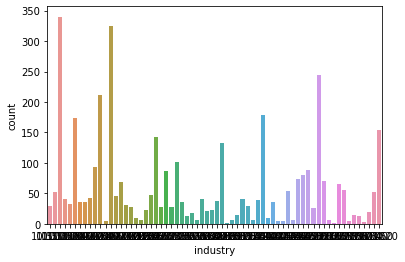

In [12]:
import seaborn as sns
sns.countplot('industry',data=des)

In [14]:
np.sum(des.industry.value_counts()<5)

7

In [9]:
def lr_sch(epoch):
    return 1 / (epoch + 1)

In [10]:
tol = 0.001
maxiter = 800
update_interval = 100
n_clusters = 59
n_epochs = 200
batch_size_auto = 128
batch_size = 64
init = glorot_uniform()
pretrain_optimizer = SGD(lr=0.001, momentum=0.9)
optimizer = SGD(lr=0.1, momentum=0.9, decay=0.0001 / n_epochs)
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_sch, verbose=0)
early_stopping = keras.callbacks.EarlyStopping(
    monitor="loss", min_delta=0.0002, patience=5
)
logdir = "logs/fit/CHNBert"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
output = []
kmeans = KMeans(n_clusters=n_clusters)

In [11]:
for key, input in all_data.items():
    input_x = input.iloc[:, 1:]
    dims = [input_x.shape[-1], 500, 200, 2000, 50]
    autoencode, encoder = autoencoder(dims, act="relu", init=init, dropout=0.2)
    autoencode.compile(optimizer=pretrain_optimizer, loss="mse")
    autoencode.fit(
        input_x,
        input_x,
        batch_size=batch_size,
        epochs=n_epochs,
        callbacks=[lr_scheduler, early_stopping],
    )
    kmeans = kmeans.fit(encoder.predict(input_x))
    y_init = kmeans.cluster_centers_
    loss = 0
    index = 0
    index_array = np.arange(input_x.shape[0])
    clustering_layer = ClusteringLayer(
        n_clusters=n_clusters, name="clustering", weights=[y_init]
    )(encoder.output)
    model = Model(inputs=encoder.input, outputs=[autoencode.output, clustering_layer])
    model.compile(loss=["mse", "kld"], loss_weights=[0.1, 1], optimizer=optimizer)
    y_pred_last = kmeans.predict(encoder.predict(input_x))
    print("the clustering training on " + key)
    for ite in range(maxiter):
        if ite % update_interval == 0:
            _, q = model.predict(input_x, verbose=0)
            p = target_distribution(q)  # update the auxiliary target distribution p

            # evaluate the clustering performance
            y_pred = q.argmax(1)

            # check stop criterion
            delta_label = (
                np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
            )
            y_pred_last = np.copy(y_pred)
            if ite != 0:
                print("the " + str(ite) + "th training on " + key + ". Loss:" + str(loss))
            if ite > 0 and delta_label < tol:
                print("delta_label = ", delta_label, " < %d" % tol)
                print("Reached tolerance threshold. Stopping training.")
                break
        idx = index_array[
            index * batch_size : min((index + 1) * batch_size, input_x.shape[0])
        ]
        loss = model.train_on_batch(x=input_x.iloc[idx], y=[input_x.iloc[idx], p[idx]])
        index = index + 1 if (index + 1) * batch_size <= input_x.shape[0] else 0
    _, q = model.predict(input_x, verbose=0)
    clas = pd.DataFrame(np.argmax(q, 1), columns=[key])
    clas.insert(0, "company", input["company"])
    output.append(clas)

Train on 3798 samples
Epoch 1/200
3798/3798 [==============================] - 2s 651us/sample - loss: 0.1121
Epoch 2/200
3798/3798 [==============================] - 0s 112us/sample - loss: 0.0329
Epoch 3/200
3798/3798 [==============================] - 0s 113us/sample - loss: 0.0279
Epoch 4/200
3798/3798 [==============================] - 0s 113us/sample - loss: 0.0267
Epoch 5/200
3798/3798 [==============================] - 0s 111us/sample - loss: 0.0263
Epoch 6/200
3798/3798 [==============================] - 0s 115us/sample - loss: 0.0261
Epoch 7/200
3798/3798 [==============================] - 0s 113us/sample - loss: 0.0254
Epoch 8/200
3798/3798 [==============================] - 0s 110us/sample - loss: 0.0252
Epoch 9/200
3798/3798 [==============================] - 0s 112us/sample - loss: 0.0251
Epoch 10/200
3798/3798 [==============================] - 0s 112us/sample - loss: 0.0247
Epoch 11/200
3798/3798 [==============================] - 0s 113us/sample - loss: 0.0246
Epoch 12

In [12]:
kmean_cluster=ML_cluster(all_data['bag of words'].iloc[:,1:],all_data['bag of words']['company'])
kmean_df=kmean_cluster.generate_clusters('kmean',n_clusters=n_clusters).output_clusters_df()

In [13]:
paper_df=pd.read_csv('paper_cn.csv',index_col=0)

In [14]:
from sklearn.preprocessing import LabelEncoder

official_df = des[["company", "industry"]]
le = LabelEncoder()
le_class = le.fit_transform(official_df["industry"])
# word_class=official_df['official_class']
official_df["industry"] = le_class
combiner = combine_models()
all_df = [official_df, paper_df, kmean_df] + output
all_cluster = combiner.get_combine_cluster(all_df)
all_cluster.head()

F:\programs\Miniconda3\envs\hejj3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,company,industry,paper_class,kmean_class,bert,bag of words,pvdm 50 length,pvdbow 50 length,pvdm 100 length,pvdbow 100 length,...,lsi 200 length,lsi 300 length,lsi 400 length,lsi 500 length,lsi 600 length,lsi 700 length,lsi 800 length,lsi 900 length,lsi 1000 length,lsi 1100 length
0,600000.SH,44,13,16,53,13,23,13,27,49,...,1,2,8,18,43,36,41,27,35,18
1,600004.SH,20,12,20,53,12,17,13,23,49,...,30,38,9,42,18,33,36,11,24,3
2,600006.SH,22,39,9,53,11,17,13,23,49,...,14,38,11,16,50,32,58,28,24,6
3,600007.SH,65,36,54,53,31,43,13,50,49,...,4,12,52,38,0,36,18,29,16,47
4,600008.SH,63,1,20,53,50,17,13,50,49,...,52,24,9,42,12,32,36,11,9,41


In [15]:
all_cluster.to_csv("all_cluster_chn_seg.csv")

In [2]:
all_cluster=pd.read_csv("all_cluster_chn_seg.csv",index_col=0)

In [5]:
price = ret.reset_index(drop=False)[["symbol", "date", "adjusted"]]
price.rename(columns={"symbol": "company", "adjusted": "return"}, inplace=True)
price["company"] = price["company"].str.replace("SS","SH",regex=False)
retu = price.groupby(by=["company"])["return"].pct_change()
price["return"] = retu
price.dropna(inplace=True)
price.reset_index(drop=True, inplace=True)
price["date"] = pd.to_datetime(price["date"], format="%Y-%m-%d")
price.head()

,company,date,return
0,603363.SH,2017-09-27,0.100000
1,603363.SH,2017-09-28,0.100132
2,603363.SH,2017-09-29,0.100599
3,603363.SH,2017-10-09,0.100109
4,603363.SH,2017-10-10,0.099901


In [16]:
# valid samples for input
cc=price.pivot(index="date", columns="company", values="return").dropna(1, thresh=60).columns
all_cluster.merge(pd.DataFrame(cc,columns=['company']),how='inner',on='company').shape

(3246, 32)

In [10]:
from combine_models import *
performance = performance_analysis('return_performance',class_df=all_cluster, return_df=price)
#performance.get_daily_return()
#performance.get_statistical_describe()
#performance.print_table()
performance.get_wellness()
performance.R2

F:\OneDrive - National University of Singapore\NLP Project\src\Chn_market\combine_models.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.return_map[name][cl].dropna(1,'all',inplace=True)
F:\OneDrive - National University of Singapore\NLP Project\src\Chn_market\combine_models.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.return_map[name][cl]['return']=self.return_map[name][cl].mean(1)
F:\programs\Miniconda3\envs\hejj3\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope

[('industry', 0.44663231601337605),
 ('paper_class', 0.4107046244595517),
 ('kmean_class', 0.42376965062940697),
 ('bert', 0.3497893116527856),
 ('bag of words', 0.39401433419393167),
 ('pvdm 50 length', 0.3975706000253481),
 ('pvdbow 50 length', 0.44671421520994814),
 ('pvdm 100 length', 0.3860679580763936),
 ('pvdbow 100 length', 0.3497893116527856),
 ('pvdm 150 length', 0.38005243485418316),
 ('pvdbow 150 length', 0.3497893116527856),
 ('pvdm 200 length', 0.3795180497024952),
 ('pvdbow 200 length', 0.4112112800879603),
 ('pvdm 250 length', 0.38270455943561854),
 ('pvdbow 250 length', 0.37920570742888665),
 ('pvdm 300 length', 0.3873511601947993),
 ('pvdbow 300 length', 0.44357095721838724),
 ('pvdm 350 length', 0.3815597115547324),
 ('pvdbow 350 length', 0.4004658039170988),
 ('pvdm 400 length', 0.40095373779314786),
 ('pvdbow 400 length', 0.3918136120944938),
 ('lsi 200 length', 0.41822460878144924),
 ('lsi 300 length', 0.42800672949012475),
 ('lsi 400 length', 0.41977770471248926)

In [18]:
from new_combine_models import *
performance = performance_analysis(class_df=all_cluster, return_df=price)
performance.get_daily_return()
performance.get_statistical_describe()
performance.print_table()

F:\OneDrive - National University of Singapore\NLP Project\src\Chn_market\new_combine_models.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.return_map[name][cl].dropna(1, thresh=ret_comp, inplace=True)
F:\programs\Miniconda3\envs\hejj3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs
F:\OneDrive - National University of Singapore\NLP Project\src\Chn_market\new_combine_models.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

summary table:


,R2,proportion of right classification,classes number
industry,0.453548,0.696701,58.0
kmean_class,0.448214,0.627673,59.0
lsi 500 length,0.435572,0.49664,39.0
paper_class,0.432357,0.64325,56.0
lsi 400 length,0.426649,0.469456,38.0
lsi 600 length,0.426457,0.467013,32.0
pvdbow 300 length,0.424441,0.482896,43.0
lsi 800 length,0.423466,0.437385,30.0
lsi 300 length,0.41623,0.497557,33.0
lsi 200 length,0.415195,0.467013,35.0
